# Worldbuilding - Meshes

In [1]:
#|default_exp meshes

In [2]:
#|export
import warnings
warnings.filterwarnings('ignore')
import trimesh
import numpy as np
import jax.numpy as jnp
from pathlib import Path
import pythreejs as p3s

from xsight.pose import pack_pose, lift_pose, unpack_pose, look_at, from_euler

In [3]:
#|export
def create_cuboid(width=1., height=1., depth=1.):
    vertices = [
        [0, 0, 0],               # Vertex 0 (bottom-front-left)
        [width, 0, 0],           # Vertex 1 (bottom-front-right)
        [width, height, 0],      # Vertex 2 (top-front-right)
        [0, height, 0],          # Vertex 3 (top-front-left)
        [0, 0, depth],           # Vertex 4 (bottom-back-left)
        [width, 0, depth],       # Vertex 5 (bottom-back-right)
        [width, height, depth],  # Vertex 6 (top-back-right)
        [0, height, depth]       # Vertex 7 (top-back-left)
    ]
    faces = [
        [0, 1, 2, 3],  # Front face
        [1, 5, 6, 2],  # Right face
        [5, 4, 7, 6],  # Back face
        [4, 0, 3, 7],  # Left face
        [3, 2, 6, 7],  # Top face
        [4, 5, 1, 0]   # Bottom face
    ]

    cuboid_mesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False)
    cuboid_mesh.fix_normals()

    return cuboid_mesh


def create_box(width=1., height=1., depth=1.):
    b = trimesh.primitives.Box(extents=(width, height, depth), transform=None, bounds=None, mutable=True)
    return b.vertices, b.faces

def create_cube(size=1.):
    return create_box(size, size, size)

def create_sphere(radius=1.0, subdivisions=0):
    s = trimesh.primitives.Sphere(radius=radius, center=np.zeros(3), subdivisions=subdivisions)
    return s.vertices, s.faces

In [4]:
#|export
def create_pyramid(width=1.,height=1.,depth=1.):
    w,h,d = width,height,depth
    vertices = [
        [0, 0, 0],  # Base vertex 1
        [w, 0, 0],  # Base vertex 2
        [w, h, 0],  # Base vertex 3
        [0, h, 0],  # Base vertex 4
        [w/2, h/2, d]  # Apex vertex
    ]
    faces = [
        [0, 2, 1],  # Base face 1 (reversed order)
        [0, 3, 2],  # Base face 2 (reversed order)
        [0, 1, 4],  # Side face 1
        [1, 2, 4],  # Side face 2
        [2, 3, 4],  # Side face 3
        [3, 0, 4]   # Side face 4
    ]

    mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
    mesh.fix_normals()
    return mesh

In [5]:
#|export
def move_to_xy(mesh, x, y):
    current_center = (np.min(mesh.vertices, axis=0) + np.max(mesh.vertices, axis=0))/2
    translation    = [x - current_center[0], y - current_center[1], 0]
    mesh_ = mesh.copy()
    mesh_.vertices += translation

    return mesh_


def move_to_z(mesh, z):
    translation = [0, 0, z - np.min(mesh.vertices[:,2])]
    mesh_ = mesh.copy()
    mesh_.vertices += translation

    return mesh_


In [6]:
#|hide
import plotly.graph_objects as go

def plotly_line(a, b, c='black', width=1):
    trace = go.Scatter3d(
        showlegend=False,
        x=[a[0], b[0]],
        y=[a[1], b[1]],
        z=[a[2], b[2]],
        mode='lines',
        line=dict(
            color=c,
            width=width
        )
    )
    return trace

def plotly_lines(lines,  c='black', width=1):
    traces = [plotly_line(a, b, c=c, width=width) for (a,b) in lines]
    return traces

def go_mesh(mesh, c="white", line_c="blue"):
    vertices = mesh.vertices
    faces    = mesh.faces
    plotly_mesh = go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        color=c,
    )
    edges = np.concatenate([faces[:, [0, 1]],
                       faces[:, [1, 2]],
                       faces[:, [2, 0]]], axis=0)
    edges = np.unique(np.sort(edges, axis=1), axis=0)
    return [plotly_mesh] + plotly_lines(vertices[edges], c=line_c)

In [7]:
#|hide
def plotly_poly(x,y,z, color='red', width=3, mode="lines"):
    trace = go.Scatter3d(
        showlegend=False,
        x=x,
        y=y,
        z=z,
        mode=mode,
        marker=dict(
            color=color,
            size=4,
            line=dict(
                color=color,
                width=3,
            )
        ),
        line=dict(
            color=color,
            width=width
        )
    )
    return trace


def plotly_pose(r,t, scale=1.0, colors=['red', 'green', 'blue'], width=4):
    return [
        plotly_line(t, t+r[:,0], color=colors[0], width=width),
        plotly_line(t, t+r[:,1], color=colors[1], width=width),
        plotly_line(t, t+r[:,2], color=colors[2], width=width),
    ]


In [8]:
#|export
cube    = create_cuboid()
pyramid = create_pyramid()
table   = create_cuboid(10, 10, -0.1)

cube    = move_to_xy(cube, 1, 1)
pyramid = move_to_xy(pyramid, 0, -1)
table   = move_to_xy(table,0,0)

mesh = trimesh.util.concatenate([
    move_to_xy(cube, 2, 1), 
    move_to_xy(pyramid, 0, 0), 
    move_to_xy(table,0,0)
])

## Meshplot

- I installed via cloning the repo and calling `pip install -e .`
- https://github.com/skoch9/meshplot
- https://github.com/jupyter-widgets/pythreejs

```
                    y
                    | 
                    |
 viewer coords:     * - - x
                   /
                  z
```

In [9]:
#|export
import meshplot as mp

def mp_plot_pose(mp_viewer, t, r, scale=1.0, colors=['red', 'green', 'blue'], width=4):
    for dt, c in zip(r.T, colors):
        mp_viewer.add_lines(t[None], (t + dt)[None], 
                         shading=dict(line_width = width, line_color = c));
    return mp_viewer

In [10]:
v = mp.Viewer({
    "width": 600, 
    "height": 400, 
    "antialias": True, 
    "scale": 1., 
    "background": "#ccc", 
    "fov": 30})

v.add_mesh(mesh.vertices, mesh.faces, c=np.array([0.9,0.9,0.9]), shading={"wireframe": True, "wire_width": 2.0})
display(v._renderer)

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(color='white', intensity=0.6, positio…

```
                    y
                    | 
                    |
mp world            * - - x
coords:            /
                  /
                 z


mp cam
   z                 z y 
  /                  |/
 * - x      ---->    * - x
 |
 y


```

In [11]:
#|export
# How a CAMERA coords "naturally" 
# embed into mp viewer coords
MP_CAM_VIEW = np.array([
    [ 1.0,   0.0,  0.0],
    [ 0.0,   1.0,  0.0],
    [ 0.0,   0.0,  -1.0]
])

# MP canonical Camera rotation
MP_WORLD_VIEW = np.array([
    [ 1.0,  0.0,  0.0],
    [ 0.0,  0.0,  1.0],
    [ 0.0,  -1.0,  0.0]
])

In [12]:
cube    = create_cuboid()
pyramid = create_pyramid()
table   = create_cuboid(10, 10, -0.1)

cube    = move_to_xy(cube, 1, 1)
pyramid = move_to_xy(pyramid, 0, -1)
table   = move_to_xy(table,0,0)

mesh = trimesh.util.concatenate([
    move_to_xy(cube, 2, 1), 
    move_to_xy(pyramid, 0, 0), 
    move_to_xy(table,0,0)
])

In [13]:
#|export
import meshplot as mp
import numpy as np
#|export
# How a CAMERA coords "naturally" 
# embed into mp viewer coords
MP_CAM_VIEW = np.array([
    [ 1.0,   0.0,  0.0],
    [ 0.0,   1.0,  0.0],
    [ 0.0,   0.0,  -1.0]
])

# MP canonical Camera rotation
MP_WORLD_VIEW = np.array([
    [ 1.0,  0.0,  0.0],
    [ 0.0,  0.0,  1.0],
    [ 0.0,  -1.0,  0.0]
])

class Viewer(object):
    def __init__(self, 
                 width  = 600, 
                 height = 400, 
                 background = "#fff", 
                 fov = 40, 
                 cam_pos  = [0, 0, 10], 
                 cam_look = [0, 0, 0],
                 view_as="world",
                 view=None,
                ):
        
        # Coordinate transform
        # To adjust mp's turntable view.
        self.T = np.eye(3)
        if view is None:
            if view_as == "world": self.T = MP_WORLD_VIEW.T
        else:
            self.T = view.T


        self._v = mp.Viewer({
            "width": width, 
            "height": height, 
            "antialias": True, 
            "scale": 1.0, 
            "background": background, 
            "fov": fov})
        
        # hack to disable auto update
        self._v.__update_view_func = self._v.__update_view
        self._v.__update_view = lambda: None

        self._v._orbit.target = tuple(cam_look@self.T)
        self._v._cam.lookAt(tuple(cam_look@self.T))
        self._v._cam.position = tuple(cam_pos@self.T)
        self._v._orbit.exec_three_obj_method('update')
        self._v._cam.exec_three_obj_method('updateProjectionMatrix')


    def add_mesh(self, vs, fs, c=np.array([1,1,1]), **kwargs):
        kwargs_ = {"shading": {"wireframe": True}}
        kwargs_.update(kwargs)

        
        self._v.add_mesh(vs@self.T, fs, c=c, **kwargs_)

    def add_points(self, vs, c=np.array([[1,1,1]]), s=1.0):
        self._v.add_points(vs@self.T, c=c, shading={"point_size": s})

    def add_pose(self, p, colors=['red', 'green', 'blue'], width=4, scale=1.0):
        x, r = unpack_pose(p)
        x = x@self.T
        for dx, c in zip(r.T, colors):
            self._v.add_lines(x[None], (x + dx@self.T)[None], 
                         shading=dict(line_width = width, line_color = c));


        return self
        
    def _repr_mimebundle_(self, **kwargs):
        return self._v._renderer._repr_mimebundle_(**kwargs)

    def look_at(self, look):
        self._v._cam.lookAt(tuple(look@self.T))
        # self._v._orbit.target = look
        self._v._orbit.exec_three_obj_method('update')
        self._v._cam.exec_three_obj_method('updateProjectionMatrix')
        return self

    def look_from(self, pos):
        self._v._cam.position = tuple(pos@self.T)
        self._v._cam.exec_three_obj_method('updateProjectionMatrix')
        return self

In [14]:
cube    = create_cuboid()
pyramid = create_pyramid()
table   = create_cuboid(10, 10, -0.1)


mesh = trimesh.util.concatenate([
    move_to_xy(cube, 2, 1), 
    move_to_xy(pyramid, 0, 0), 
    move_to_xy(table,0,0)
])

In [15]:
p = pack_pose(
    jnp.array([0,0,2]),
    look_at(jnp.array([2,1,-1]))
)


In [18]:
MP_CAM_VIEW = np.array([
    [ 1.0,   0.0,  0.0],
    [ 0.0,   1.0,  0.0],
    [ 0.0,   0.0,  1.0]
])

v = Viewer(cam_pos=(0,0,10), cam_look=np.array([0,0,0]), view_as="world")
v.add_mesh(mesh.vertices, mesh.faces)
v.add_pose(p)
v.add_points(2*np.random.randn(100,3), c=np.random.rand(100,3))
v

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(color='white', intensity=0.6, positio…

## Lifting from 2D worlds to 3D

In [21]:
#|export

def trimesh_from_2d_segs(segs):
    pieces = []
    for s in segs:
        x = s[:2]
        y = s[2:]

        p = pack_pose(np.concatenate([(x + y)/2 , np.array([0.5])]), np.eye(3))

        dimensions = np.array(np.concatenate([np.abs(x - y) , np.array([1.0])]))
        piece = trimesh.creation.box(dimensions, p)
        pieces.append(piece)

    map_mesh = trimesh.util.concatenate(pieces)
    return map_mesh

In [44]:
#|export
import json 

def load_env_data(fname):
    with open(fname) as f:
        data = json.load(f)

    return data

def unpack_2d_env_data(fname):
    data = load_env_data(fname)

    segs   = np.array(data["segs"])

    # Convert clutter verts to segs
    clutter = np.array(data["clutter_verts"])
    clutter = data["clutter_verts"]
    clutter = np.array(clutter)
    clutter = np.stack([clutter[:,:-1,:], clutter[:,1:,:]], axis=2)
    clutter = np.concatenate(clutter, axis=0).reshape(-1,4)

    xs  = np.array(data["paths"][0])
    dxs = xs[1:] - xs[:-1]
    hds = np.arctan2(dxs[:, 1], dxs[:, 0])
    dhds = hds[1:] - hds[:-1]
    xs  = xs[:-1]
    T   = len(xs)
    return segs, clutter, xs, hds, dxs[:-1], dhds

dict_keys(['env_name', 'paths', 'verts', 'clutter_verts', 'segs', 'clutter_segs'])
(80, 2, 2)


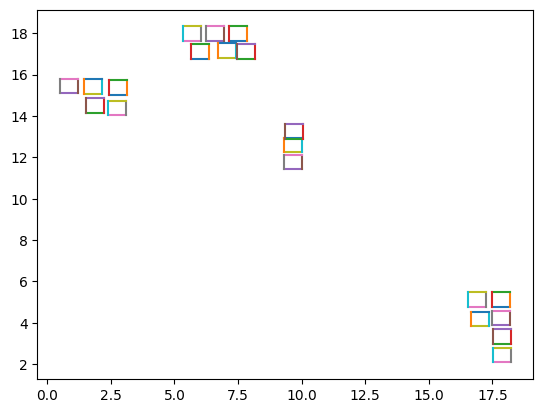

In [43]:
import matplotlib.pyplot as plt

fname = "./data/test_env_2d.json"
data = load_env_data(fname)
print(data.keys())
clutter = data["clutter_verts"]
clutter= np.array(clutter)

clutter = np.stack([clutter[:,:-1,:], clutter[:,1:,:]], axis=2)
clutter = np.concatenate(clutter, axis=0)
print(clutter.shape)

for s in clutter:
    plt.plot(s[:,0],s[:,1])

(426, 4) (50, 2) (50,) (49, 2) (49,)


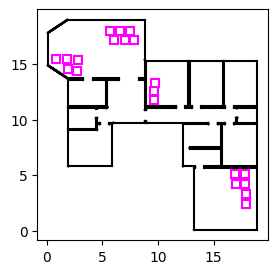

In [49]:
fname = "./data/test_env_2d.json"
segs, clutter, xs, hds, dxs, dhds = unpack_2d_env_data(fname)
T = len(xs)

print(segs.shape, xs.shape,  hds.shape, dxs.shape, dhds.shape)


# ---------------------------
plt.figure(figsize=(3,3))
plt.gca().set_aspect(1)
for s in segs.reshape(-1,2,2):
    plt.plot(s[:,0],s[:,1], c="k")

for s in clutter.reshape(-1,2,2):
    plt.plot(s[:,0],s[:,1], c="magenta")

In [190]:
mesh = trimesh_from_2d_segs(segs)
mesh = move_to_xy(mesh, 0, 0)
table   = create_cuboid(20, 20, -0.1)
table   = move_to_xy(table, 0, 0)

v = Viewer(cam_pos=(0,-25,15), cam_look=np.array([0,0,0]), background="#eee", turntable_axis="z")
v.add_mesh(mesh.vertices, mesh.faces, c=np.array([.9,.0,.9]))
v.add_mesh(table.vertices, table.faces, c=np.array([.9,.9,.9]))
v

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(color='white', intensity=0.6, positio…